In [140]:
# !pip install wandb

In [141]:
# !git clone https://github.com/linklab/link_dl.git

In [142]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets
from torchvision.transforms import transforms
import sys
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torch.utils.data.dataset import Subset
from torch.nn.functional import softmax
from torchviz import make_dot
from torchsummary import summary
from datetime import datetime
import argparse

In [143]:
BASE_PATH = "/Users/yangdongjae/Desktop/link_dl-main"
sys.path.append(BASE_PATH)

In [144]:
from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

## Lecture Approach Method

In [145]:
def get_mean_std(imgs):
  mean = imgs.view(1, -1).mean(dim = -1)
  std = imgs.view(1, -1).std(dim = -1)

  return mean, std

In [146]:
def get_fashion_mnist_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))
  print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

  num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
  print("Number of Data Loading Workers:", num_data_loading_workers)

  train_data_loader = DataLoader(
    dataset=f_mnist_train,
     batch_size=wandb.config.batch_size,
     shuffle=True,
    pin_memory=True,
     num_workers=num_data_loading_workers,
     drop_last = True
  )

  validation_data_loader = DataLoader(
    dataset=f_mnist_validation,
     batch_size=wandb.config.batch_size,
     pin_memory=True,
     num_workers=num_data_loading_workers,
     drop_last = True
  )

  imgs = torch.stack([img_t for img_t, _ in train_data_loader], dim = 3)
  x, y = get_mean_std(imgs)

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=x, std=y),
  )

  return train_data_loader, validation_data_loader, f_mnist_transforms


In [147]:
def get_fashion_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
  f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

  print("Num Test Samples: ", len(f_mnist_test))
  print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

  test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

  imgs = torch.stack([img_t for img_t, _ in test_data_loader], dim = 3)
  x, y = get_mean_std(imgs)

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=x, std=y),
  )

  return f_mnist_test_images, test_data_loader, f_mnist_transforms


In [148]:
config = {'batch_size': 2048,}
wandb.init(mode="disabled", config=config)

train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
print()
f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


In [149]:
to_tensor(f_mnist_test_images[0][0]).mean()

tensor(0.1673)

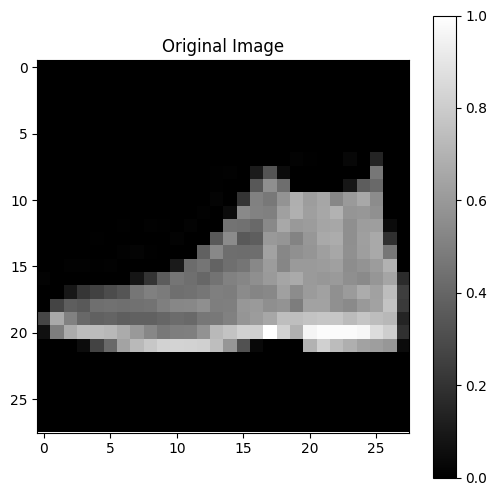

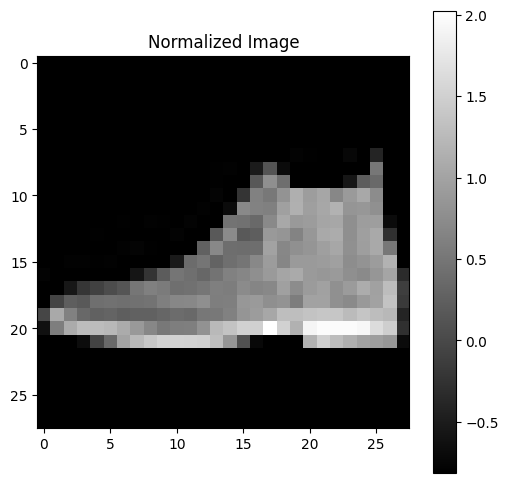

In [150]:
pil_image = f_mnist_test_images[0][0]
image_tensor = to_tensor(pil_image)
normalized_image_tensor = f_mnist_transforms(image_tensor)

def show_image(img_tensor, title=''):
    # If image has been normalized, denormalize it for visualization
    if img_tensor.ndimension() == 3:
        img_tensor = img_tensor.squeeze(0)  # Remove channel dimension if it's a single image

    np_img = img_tensor.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(np_img, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

show_image(image_tensor, title='Original Image')
show_image(normalized_image_tensor, title='Normalized Image')

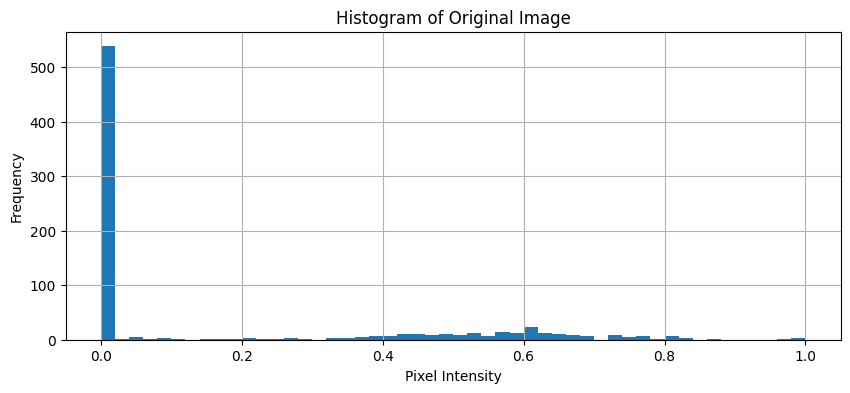

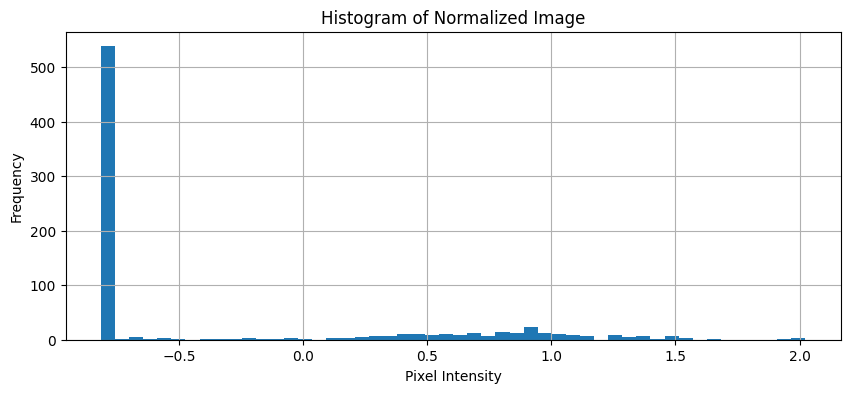

In [151]:
# Function to plot the histogram
def plot_histogram(img_tensor, title):
    np_img = img_tensor.numpy().flatten()
    plt.figure(figsize=(10, 4))
    plt.hist(np_img, bins=50)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot histogram for the original and normalized images
plot_histogram(image_tensor, 'Histogram of Original Image')
plot_histogram(normalized_image_tensor, 'Histogram of Normalized Image')

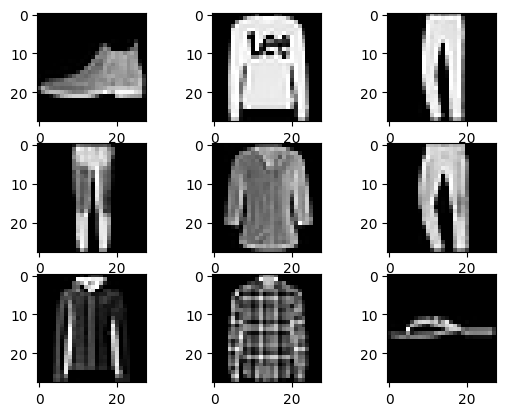

In [152]:
for i in range (9):
  plt.subplot(330 + 1 + i)
  plt.imshow(f_mnist_test_images[i][0], cmap = plt.get_cmap('gray'))
plt.show()

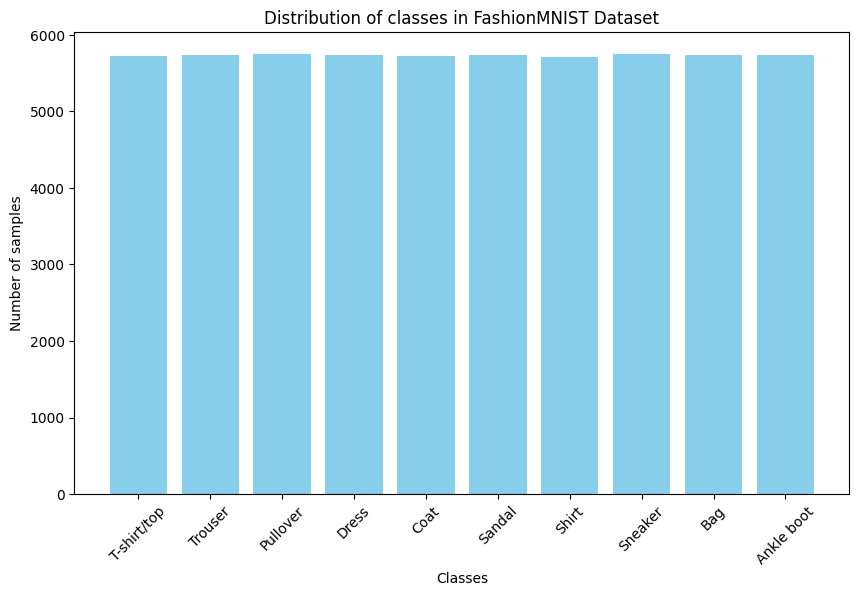

In [153]:
label_count = [0] * 10

# Iterate over the training data loader to count labels
for _, labels in train_data_loader:
    for label in labels:
        label_count[label.item()] += 1

# Adding counts from the validation data loader
for _, labels in validation_data_loader:
    for label in labels:
        label_count[label.item()] += 1

# Class names in FashionMNIST (for better visualization)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, label_count, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Distribution of classes in FashionMNIST Dataset')
plt.xticks(rotation=45)
plt.show()

# Utils

In [154]:
from datetime import datetime
import os
import torch
from torch import nn

from _01_code._99_common_utils.utils import strfdelta


class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.0001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:6.3f} --> {new_validation_loss:6.3f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss


class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      input_train = self.transforms(input_train)

      output_train = self.model(input_train)
      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:6.4f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:6.4f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [155]:
def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=1000, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-3, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=10,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=10,
    help="Number of early stop patience (int, default: 10)"
  )

  return parser


# My Approach

In [ ]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")
    train_transforms = transforms.Compose([
        
    ])


    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])
    
    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])
    
    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)
    
    train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=wandb.config.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_data_loading_workers,
        drop_last = True
    )
    
    validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_data_loading_workers,
        drop_last = True
    )
    
    imgs = torch.stack([img_t for img_t, _ in train_data_loader], dim = 3)
    x, y = get_mean_std(imgs)
    
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=x, std=y),
    )
    
    return train_data_loader, validation_data_loader, f_mnist_transforms


In [157]:
config = {'batch_size': 2048,}
wandb.init(mode="disabled", config=config)

my_train_data_loader, my_validation_data_loader, my_f_mnist_transforms = my_get_fashion_mnist_data()
print()
my_f_mnist_test_images, my_test_data_loader, my_f_mnist_transforms = my_get_fashion_mnist_test_data()

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


# My Model

In [ ]:
def get_my_model():
    class MyModel(nn.Module):
        def __init__(self, num_classes):
            super(MyModel, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(32)
            self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(32)
            self.pool = nn.MaxPool2d(3, 3)
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(32 * 9 * 9, 64)  # 계산된 입력 차원
            self.fc2 = nn.Linear(64, num_classes)

        def forward(self, x):
            x = torch.relu(self.bn1(self.conv1(x)))
            x1 = torch.relu(self.bn2(self.conv2(x)))
            x2 = torch.relu(self.bn3(self.conv3(x1)))

            # Attention 적용
            att = torch.bmm(x1.view(x1.size(0), x1.size(1), -1).transpose(1, 2), x2.view(x2.size(0), x2.size(1), -1))
            att = softmax(att, dim=2)
            x_att = torch.bmm(x2.view(x2.size(0), x2.size(1), -1), att.transpose(1, 2)).view_as(x2)

            x = self.pool(x_att)
            x = self.flatten(x)
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x
    
    my_model = MyModel(10)
    
    return my_model

In [ ]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    
    config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience
    }
    
    project_name = 'Fashion_MNIST'
    wandb.init(
        mode = "online" if args.wandb else "disabled",
        project = project_name,
        notes = "Assignment #3 with Fashion MNIST dataset",
        tags = ["ComputerVision", "ImageClassification","CNN"],
        name = run_time_str,
        config = config
    )
    
    print(args)
    print(wandb.config)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    print(f"Training on Device {device}")
    
    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    model = get_my_model()
    model.to(device)
    wandb.watch(model)
    
    optimizer = optim.SGD(model.parameters(), lr = wandb.config.learning_rate)
    
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, checkpoint_file_path='/Users/yangdongjae/Desktop/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints'
    )
    
    classification_trainer.train_loop()
    
    wandb.finish()

In [ ]:
parser = get_parser()
args,_ = parser.parse_known_args()
main(args)